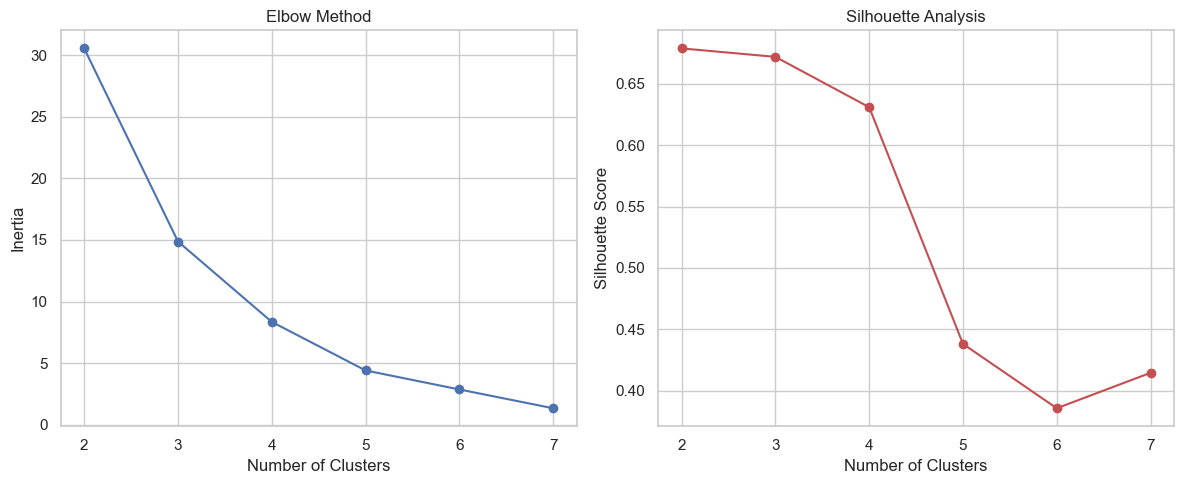

Cluster Characteristics:


cluster mean_interval           std_interval num_refills max_interval
                   mean       std         mean        mean         mean
0       0      5.953292  1.655696    12.320583  125.833333    57.916667
1       1     74.600000       NaN   166.810671    5.000000   373.000000
2       2     50.210101  5.292419    63.565296   11.000000   219.000000

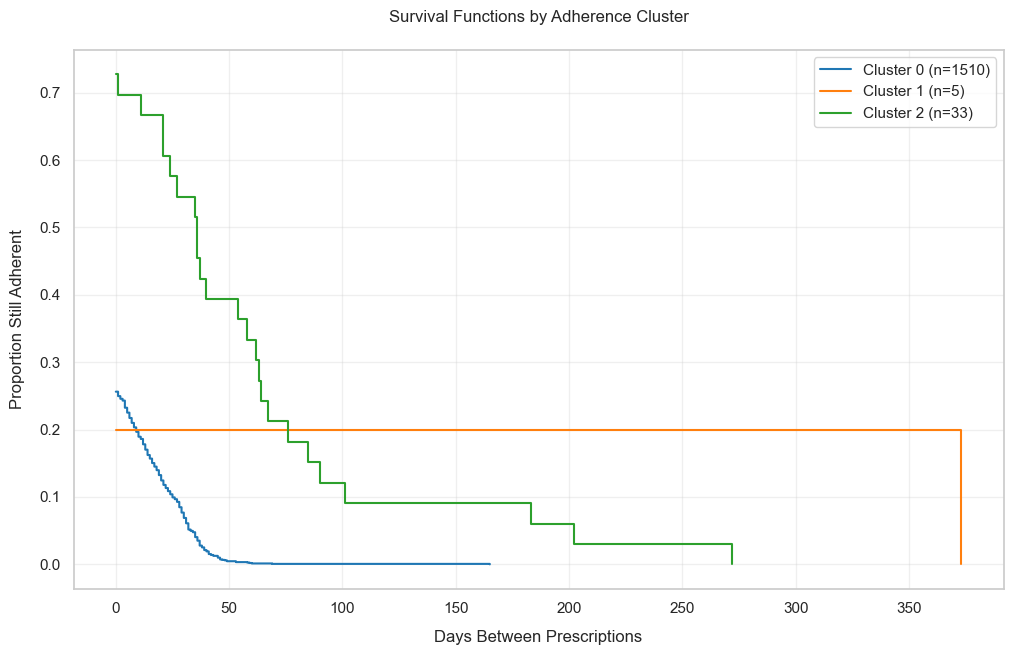


Key Insights:

Cluster 0 (12 patients):
- Average refill interval: 6.0 days
- Average number of refills: 125.8
- Typical behavior: Good adherence

Cluster 1 (1 patients):
- Average refill interval: 74.6 days
- Average number of refills: 5.0
- Typical behavior: Poor adherence

Cluster 2 (3 patients):
- Average refill interval: 50.2 days
- Average number of refills: 11.0
- Typical behavior: Moderate adherence


<Figure size 1200x600 with 0 Axes>

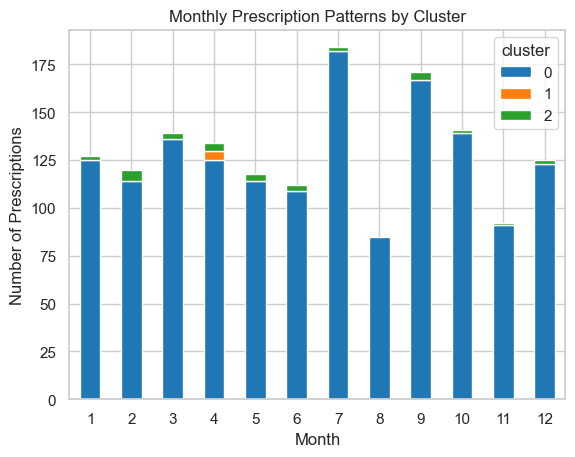

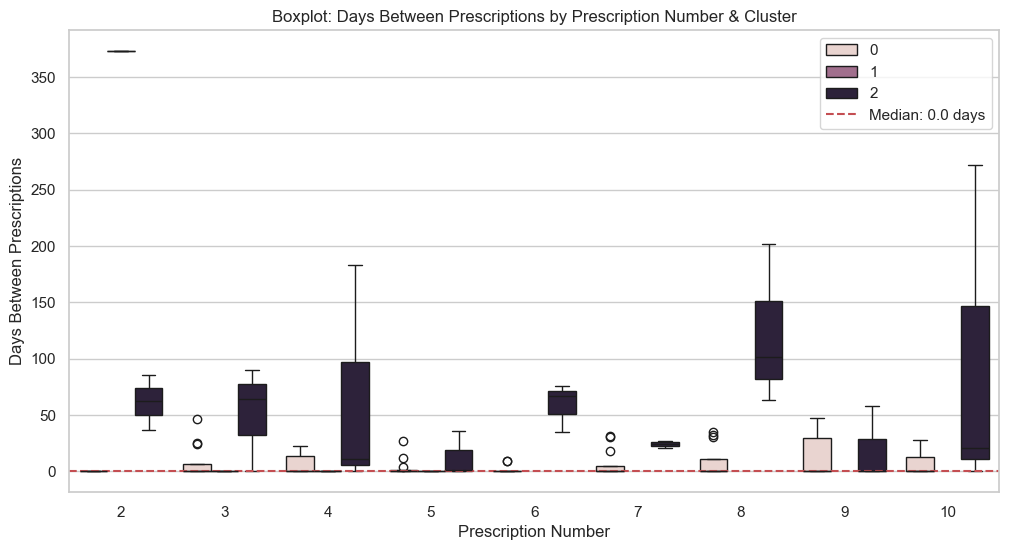

In [34]:
# %% [markdown]
# # Medication Adherence Analysis with SEE and K-Means Clustering
# 
# **Dataset**: `med_events_ATC.csv`  
# **Techniques**:  
# - Sessa Empirical Estimator (Survival Analysis)  
# - K-Means Clustering  
# - Feature Engineering

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ecdf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# %%
# Load and preprocess data
df = pd.read_csv('med_events_ATC.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values(['PATIENT_ID', 'DATE'])

# Calculate time between prescriptions
df['prev_date'] = df.groupby('PATIENT_ID')['DATE'].shift(1)
df = df.dropna(subset=['prev_date'])
df['event_interval'] = (df['DATE'] - df['prev_date']).dt.days

# Filter extreme values (>5 years)
df = df[df['event_interval'] <= 365*5]

# %%
# Feature engineering for clustering
patient_features = df.groupby('PATIENT_ID').agg(
    mean_interval=('event_interval', 'mean'),
    std_interval=('event_interval', 'std'),
    num_refills=('event_interval', 'count'),
    max_interval=('event_interval', 'max'),
    q25=('event_interval', lambda x: np.quantile(x, 0.25)),
    q75=('event_interval', lambda x: np.quantile(x, 0.75))
).reset_index()

# Handle missing values from std calculation
patient_features['std_interval'] = patient_features['std_interval'].fillna(0)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(patient_features.drop('PATIENT_ID', axis=1))

# %%
# Determine optimal k using Elbow Method
inertia = []
silhouette = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(scaled_features, kmeans.labels_))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# %%
# Final clustering with k=3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
patient_features['cluster'] = kmeans.fit_predict(scaled_features)

# Add cluster labels to original dataframe
df = df.merge(patient_features[['PATIENT_ID', 'cluster']], on='PATIENT_ID')

# %%
# Cluster analysis
cluster_stats = patient_features.groupby('cluster').agg({
    'mean_interval': ['mean', 'std'],
    'std_interval': 'mean',
    'num_refills': 'mean',
    'max_interval': 'mean'
}).reset_index()

print("Cluster Characteristics:")
display(cluster_stats)

# %%
# Sessa Estimator Implementation
def sessa_estimator(intervals):
    res = ecdf(intervals)
    x = np.sort(intervals)
    y = 1 - res.cdf.evaluate(x)
    return x, y

# Plot survival curves for each cluster
plt.figure(figsize=(12, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for cluster in range(optimal_k):
    cluster_intervals = df[df['cluster'] == cluster]['event_interval']
    x, y = sessa_estimator(cluster_intervals)
    plt.step(x, y, where='post', 
             label=f'Cluster {cluster} (n={len(cluster_intervals)})',
             color=colors[cluster])

plt.title('Survival Functions by Adherence Cluster', pad=20)
plt.xlabel('Days Between Prescriptions', labelpad=10)
plt.ylabel('Proportion Still Adherent', labelpad=10)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# %%
# Generate insights
print("\nKey Insights:")
for cluster in range(optimal_k):
    cluster_data = patient_features[patient_features['cluster'] == cluster]
    n_patients = cluster_data.shape[0]
    avg_refills = cluster_data['num_refills'].mean()
    avg_interval = cluster_data['mean_interval'].mean()
    
    print(f"\nCluster {cluster} ({n_patients} patients):")
    print(f"- Average refill interval: {avg_interval:.1f} days")
    print(f"- Average number of refills: {avg_refills:.1f}")
    print(f"- Typical behavior: {'Good adherence' if avg_interval < 30 else 'Moderate adherence' if avg_interval < 60 else 'Poor adherence'}")

# %%
def boxplot_prescription_intervals(df, cluster_label='cluster', max_prescription=10):
    """
    Creates a boxplot of event_interval by prescription number (p_number), 
    colored by the specified cluster label.
    """
    # Sort by patient and date
    df_sorted = df.sort_values(['PATIENT_ID', 'DATE']).copy()

    # Ensure there's a p_number
    df_sorted['p_number'] = df_sorted.groupby('PATIENT_ID').cumcount() + 1
    
    # Filter prescriptions (we skip the first one because it has no prior interval)
    df_filtered = df_sorted[
        (df_sorted['p_number'] >= 2) & 
        (df_sorted['p_number'] <= max_prescription)
    ].copy()

    # Plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='p_number',
        y='event_interval',
        hue=cluster_label,          # <--- Important difference: color by cluster
        data=df_filtered,
        showfliers=True
    )

    plt.title('Boxplot: Days Between Prescriptions by Prescription Number & Cluster')
    
    # Overall median across all data in df_filtered
    overall_median = df_filtered['event_interval'].median()
    plt.axhline(overall_median, color='r', linestyle='--', label=f'Median: {overall_median:.1f} days')
    
    plt.xlabel('Prescription Number')
    plt.ylabel('Days Between Prescriptions')
    plt.legend()
    plt.show()


# %%
# Temporal pattern analysis
df['month'] = df['DATE'].dt.month
monthly_clusters = df.groupby(['month', 'cluster']).size().unstack()

plt.figure(figsize=(12, 6))
monthly_clusters.plot(kind='bar', stacked=True, color=colors)
plt.title('Monthly Prescription Patterns by Cluster')
plt.xlabel('Month')
plt.ylabel('Number of Prescriptions')
plt.xticks(rotation=0)
plt.show()
boxplot_prescription_intervals(df)
